# explicit implementation of REINFORCE on short corridor switched actions

### softmax in action preferences, with preferences linear in features

- preferences linear in features

$h(s,a,\theta) = \theta^Tx(s,a)$ 
- state,action features

$x(s,right)=[0,1]^T$ and $x(s,left)=[1,0]^T$ for all s

- policy gradient episodic case performance

$J(\theta) = v_{\pi_\theta}(s_0) $

#### REINFORCE: Monte Carlo Policy Gradient
1 ) generate episode

2 ) loop over each timestep 
- compute return $G_t = \sum_{k=t}^T \gamma^{k-t-1} r_k $
- update $ \theta_{t+1} = \theta_{t} + \alpha \gamma^t G_t \nabla ln \space \pi (A_t|S_t,\theta)$

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### short corridor with switched actions

In [2]:
class Env():
  def __init__(self):
    self.st = 0
    self.t = 0
    self.maxt = 1000
    None
    
  def __call__(self,action):
    if self.st == 0:
      if action:
        stp = 1
      else:
        stp = 0
    elif self.st == 1:
      if action:
        stp = 0
      else:
        stp = 2
    elif self.st == 2:
      if action:
        stp = 3
      else:
        stp = 1
    # update internal state
    self.st = stp
    reward = -1 
    self.t += 1
    if self.t >= self.maxt:
      done = True
    elif stp == 3:
      done = True
    else:
      done = False
    return stp,reward,done
  

In [3]:
def compute_returns(rewards,gamma=1.0):
    """ 
    given rewards, compute discounted return
    G_t = sum_k [g^k * r(t+k)]; k=0...T-t
    """ 
    T = len(rewards) 
    returns = np.array([
        np.sum(np.array(
            rewards[t:])*np.array(
            [gamma**i for i in range(T-t)]
        )) for t in range(T)
    ])
    return returns
compute_returns([-1,-1,-1])

array([-3., -2., -1.])

In [4]:
sm_policy = lambda theta: np.exp(theta[1]) / np.sum(np.exp(theta))


class Agent():
  def __init__(self):
    self.theta = np.array([0,5])
    self.alpha = 2**-13
    self.gamma = 1.0
    return None
  
  def act(self):
    pr_right = sm_policy(self.theta)
    action = np.random.binomial(1,pr_right)
    return action
  
  def update(self,actions,rewards):
    """ """
    returns = compute_returns(rewards,gamma=1.0)
    L = []
    for At,Gt in zip(actions,returns):
      glp = self.compute_grad_ln_pi(At)
      self.theta = self.theta + self.alpha*Gt*glp
    return None
    
  def compute_grad_ln_pi(self,action):
    hR = np.array([0,1])
    hL = np.array([1,0])
    if action: 
      h = hR
    else:
      h = hL
    pr_right = sm_policy(self.theta)
    expectation = pr_right*hR + (1-pr_right)*hL 
    return h - expectation
      
a = Agent()
a.compute_grad_ln_pi(0)


array([ 0.99330715, -0.99330715])

- computing gradient of log-softmax [stack exchange](https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative)

$ \nabla_\theta ln\space \pi(s,a) = \phi(a) - E_\pi [\phi(s,.)]  = \phi(s,a) - ( \pi(right|s)\phi(right,s)  +\pi(left|s)\phi(left,s)) $

In [5]:
ns = 5
neps = 1000
score = np.zeros((ns,neps))

for seed in range(ns):
  agent = Agent()
  # episode loop
  for ep in range(neps):
    env = Env()
    # trial loop
    done = False
    at = 0
    A = []
    R = []
    while not done:
      st,reward,done = env(at)
      at = agent.act()
      # collect reward
      A.append(at)
      R.append(reward)
      # update
    agent.update(A,R)
    score[seed,ep] = np.sum(R)


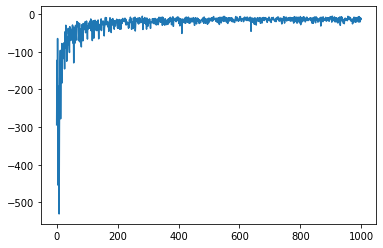

In [6]:
plt.plot(score.mean(0))

# notes on replication issues
- initially, I set episode max length to 100
    - I did this because I the book figure doesnt go below -100
- additionally, when generating the figure was doing at most 1000 episodes
    - again, I did this because the book figure seemed to assymptote around ep 500
- however,the number of updates made by the REINFORCE algorithm is proportional to episode length in this task
- the first hint came when I realized I could train from greedy to optimal in 10x more episodes
    - making max episode length 1000 helps
    - this implementation [git](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter13/short_corridor.py) does not set a max number of trials per episode, but instead hard codes an edgecase where softmax is not allowed to saturate on greedy. 